# Hackathon - Shinkansen (Bullet-Trains) of Japan

## The goal of the problem is to predict whether a passenger was delighted considering his/her overall experience of traveling in Shinkansen (Bullet Train).

In [147]:
# import the required libraries

import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
import ppscore as pps
import statistics


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve, make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings('ignore')

In [148]:
os.chdir('C:\\Users\\animdas\\Documents\\Hackathon\\GreatLearning Hackathon')

### Read the different datasets and merge into train and test

In [149]:
train_data = pd.read_csv('Traveldata_train.csv')
train_survey_data = pd.read_csv('Surveydata_train.csv')
test_data = pd.read_csv('Traveldata_test.csv')
test_survey_data = pd.read_csv('Surveydata_test.csv')

In [150]:
train_df = pd.merge(train_data, train_survey_data, how = 'left')

In [151]:
test_df = pd.merge(test_data, test_survey_data, how = 'left')

In [152]:
ID = test_df['ID']

### EDA

In [153]:
def basic_eda(df):
    print('SHAPE')
    print(df.shape)
    print('.' * 100)
    print('\nINFO')
    print(df.info())
    print('.' * 100)
    print('\nMISSING VALUES')
    print('Total Missing:', df.isna().sum().sum())
    print(df.isna().sum())
    print('.' * 100)
    print('\nDUPLICATES')
    print(df.duplicated().sum())
    print('.' * 100)  
    print('\nDESCRIBE')
    print(df.describe())
    

In [154]:
basic_eda(train_df)

SHAPE
(94379, 25)
....................................................................................................

INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   CustomerType             85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   TypeTravel               85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   DepartureDelay_in_Mins   94322 non-null  float64
 8   ArrivalDelay_in_Mins     94022 non-null  float64
 9   Overall_Experience       94379 non-null  int64  
 10  Seat_comfort             94318 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arriv

In [155]:
basic_eda(test_df)

SHAPE
(35602, 24)
....................................................................................................

INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35602 entries, 0 to 35601
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       35602 non-null  int64  
 1   Gender                   35572 non-null  object 
 2   CustomerType             32219 non-null  object 
 3   Age                      35591 non-null  float64
 4   TypeTravel               32154 non-null  object 
 5   Travel_Class             35602 non-null  object 
 6   Travel_Distance          35602 non-null  int64  
 7   DepartureDelay_in_Mins   35573 non-null  float64
 8   ArrivalDelay_in_Mins     35479 non-null  float64
 9   Seat_comfort             35580 non-null  object 
 10  Seat_Class               35602 non-null  object 
 11  Arrival_time_convenient  32277 non-null  object 
 12  Cater

In [156]:
#dropping unncessary column

train_df.drop('ID', axis = 1, inplace = True)

In [157]:
# train_df.dropna(axis = 0, subset = ['Online_boarding', 'Cleanliness', 'Onboard_entertainment', 'Onboardwifi_service',
#                                    'Platform_location', 'Age', 'DepartureDelay_in_Mins', 'Seat_comfort', 'Onlinebooking_Ease',
#                                    'Checkin_service', 'Gender', 'Leg_room', 'Online_support'], inplace = True)

In [158]:
print('Unique values in the dataset:\n')

for i in train_df.columns:
    print('_' * 50)
    print(i.upper() + ':', train_df[i].nunique(), train_df[i].dtype)
    print(train_df[i].value_counts())

Unique values in the dataset:

__________________________________________________
GENDER: 2 object
Female    47815
Male      46487
Name: Gender, dtype: int64
__________________________________________________
CUSTOMERTYPE: 2 object
Loyal Customer       69823
disloyal Customer    15605
Name: CustomerType, dtype: int64
__________________________________________________
AGE: 75 float64
39.0    2688
25.0    2542
40.0    2333
44.0    2291
41.0    2248
        ... 
73.0      47
79.0      39
76.0      38
78.0      30
85.0      18
Name: Age, Length: 75, dtype: int64
__________________________________________________
TYPETRAVEL: 2 object
Business travel    58617
Personal Travel    26536
Name: TypeTravel, dtype: int64
__________________________________________________
TRAVEL_CLASS: 2 object
Eco         49342
Business    45037
Name: Travel_Class, dtype: int64
__________________________________________________
TRAVEL_DISTANCE: 5210 int64
1963    72
1789    68
1639    65
1894    65
1767    64
     

In [159]:
#replacing the extremely few records in features and clubbing them with the next best level  

train_df['Platform_location'].replace('very inconvinient', 'Inconvinient', inplace = True)
train_df['Onboardwifi_service'].replace('extremely poor', 'poor', inplace = True)
train_df['Online_support'].replace('extremely poor', 'poor', inplace = True)
train_df['Onlinebooking_Ease'].replace('extremely poor', 'poor', inplace = True)
train_df['Onboard_service'].replace('extremely poor', 'poor', inplace = True)
train_df['Checkin_service'].replace('extremely poor', 'poor', inplace = True)
train_df['Cleanliness'].replace('extremely poor', 'poor', inplace = True)
train_df['Online_boarding'].replace('extremely poor', 'poor', inplace = True)

In [160]:
# separating numerical and categorical train data

num_train_df = train_df.select_dtypes(exclude = 'object')
cat_train_df = train_df.select_dtypes(include = 'object')

In [161]:
# separating numerical and categorical test data

num_test_df = test_df.select_dtypes(exclude = 'object')
cat_test_df = test_df.select_dtypes(include = 'object')

Text(0.5, 1.02, 'Distribution Plot for Numeric Data')

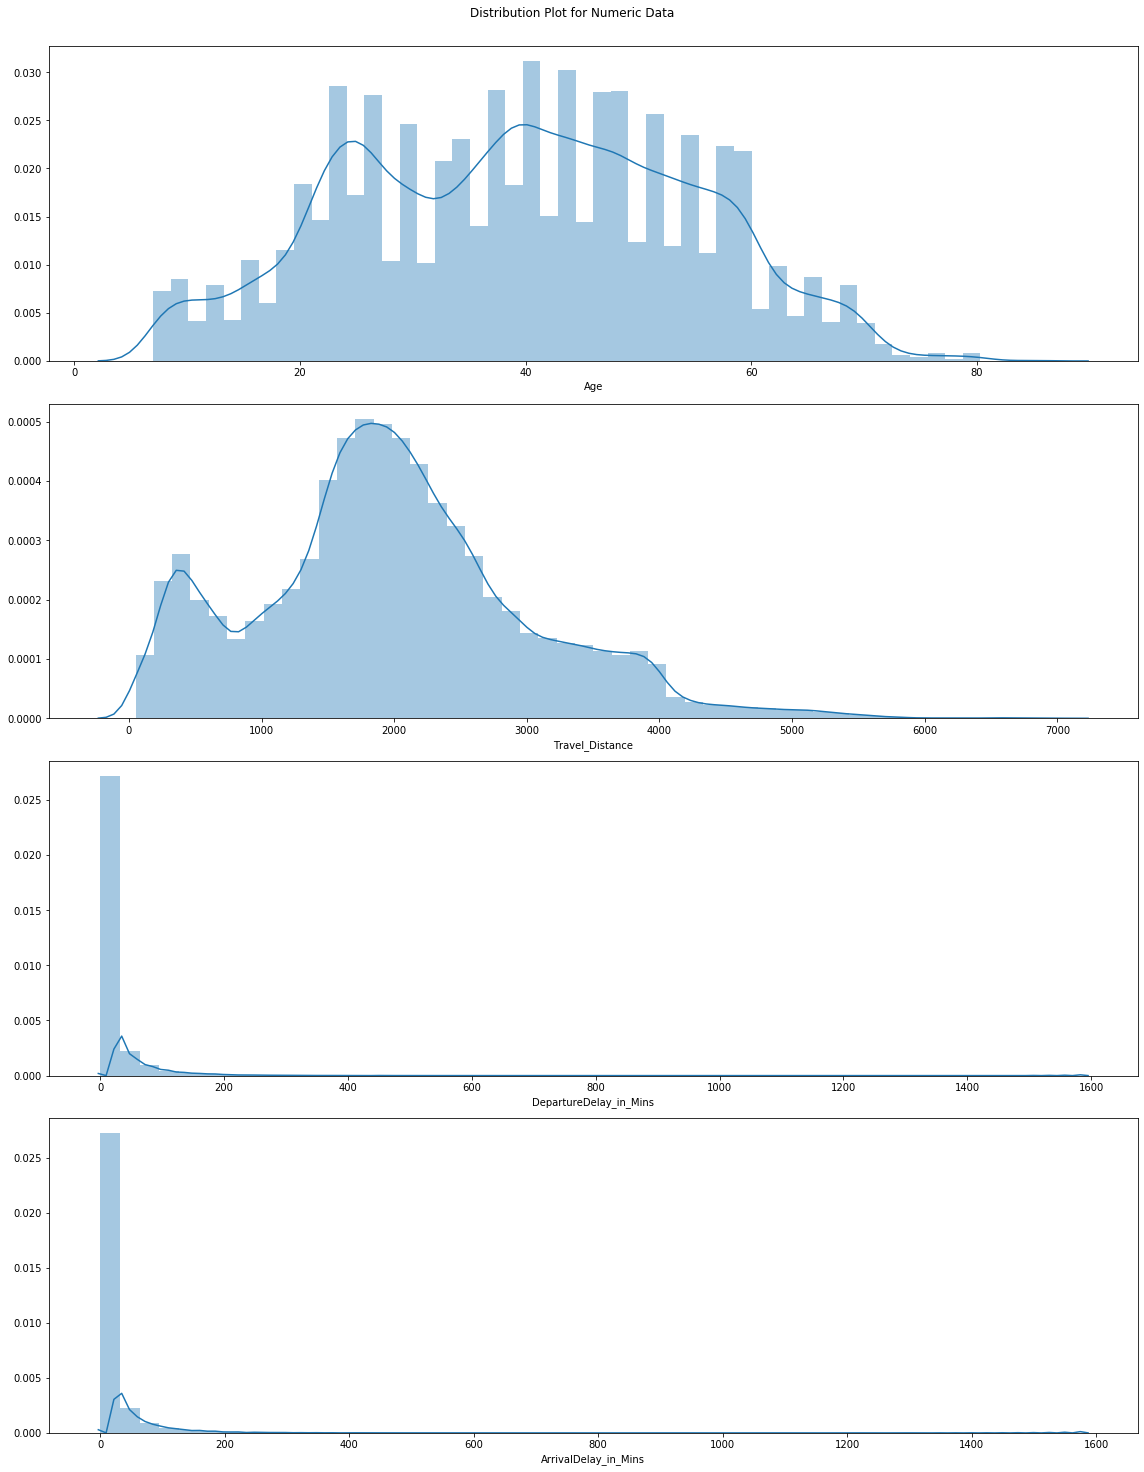

In [162]:
fig, axes = plt.subplots(figsize = (16, 20), nrows = 4, ncols = 1)

for i, col in enumerate(num_train_df.columns[0:4]):
    sns.distplot(num_train_df[col], ax = axes[i])
    
plt.tight_layout()
plt.suptitle('Distribution Plot for Numeric Data', y = 1.02)

In [163]:
num_train_df.columns

Index(['Age', 'Travel_Distance', 'DepartureDelay_in_Mins',
       'ArrivalDelay_in_Mins', 'Overall_Experience'],
      dtype='object')

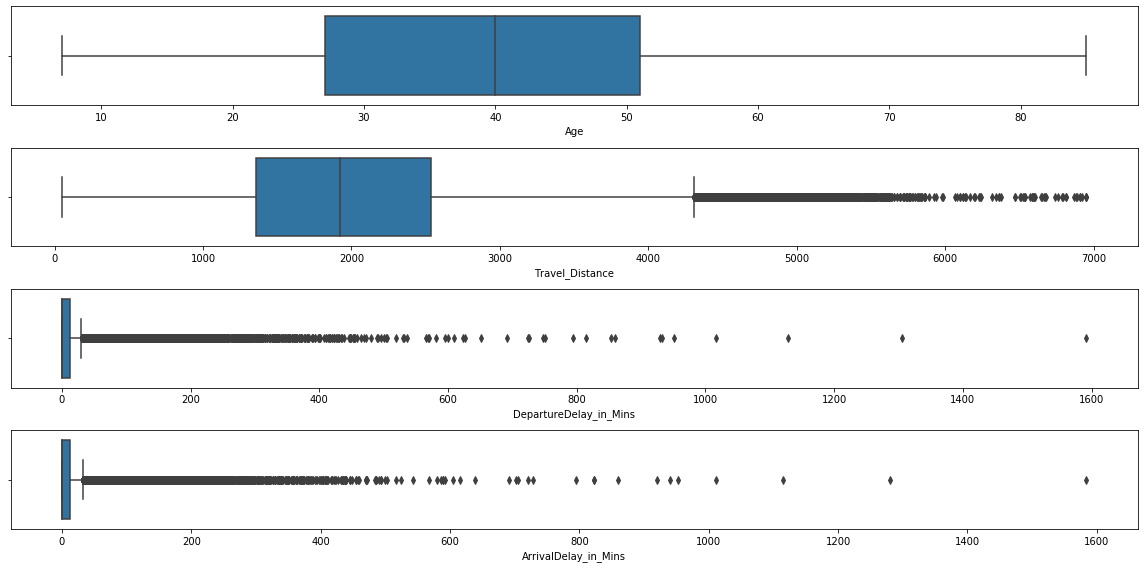

In [164]:
fig, axes = plt.subplots(figsize = (16, 8), nrows = 4, ncols = 1)

for i, col in enumerate(num_train_df.columns[0:4]):
    sns.boxplot(num_train_df[col], ax = axes[i])
    
plt.tight_layout()

In [165]:
# train_df['DepartureDelay_in_Mins'].sort_values(ascending = False).head(10)

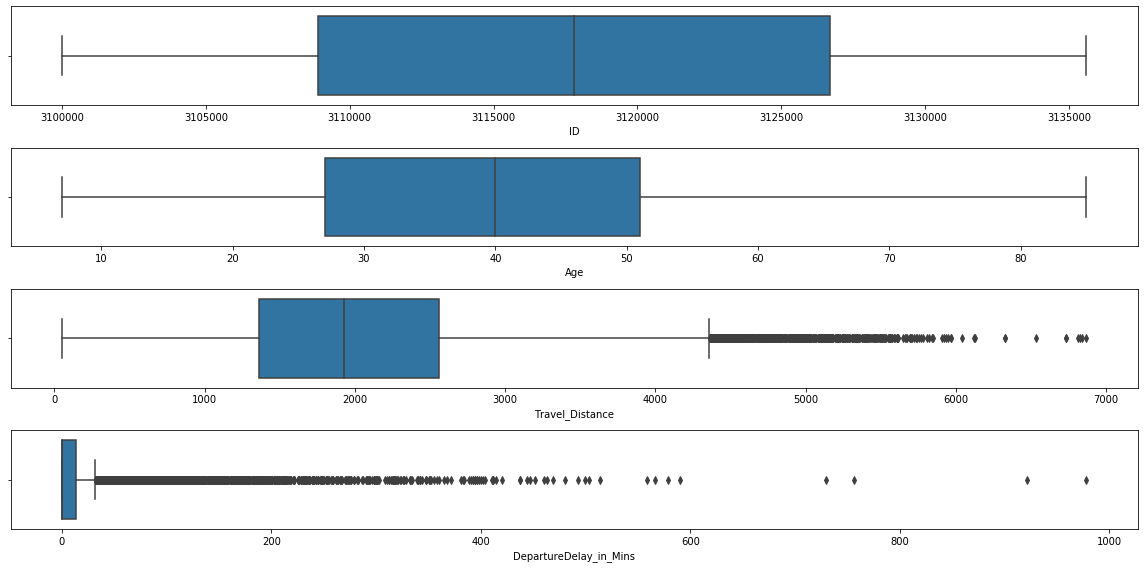

In [166]:
fig, axes = plt.subplots(figsize = (16, 8), nrows = 4, ncols = 1)

for i, col in enumerate(num_test_df.columns[0:4]):
    sns.boxplot(num_test_df[col], ax = axes[i])
    
plt.tight_layout()

In [167]:
# outlier analysis

Q1 = num_train_df.quantile(0.25)
Q3 = num_train_df.quantile(0.75) 
IQR = Q3 - Q1 
lower_range = (Q1 - 1.5 * IQR)
upper_range = (Q3 + 1.5 * IQR)
extreme_lower_range = (Q1 - 3 * IQR)
extreme_upper_range = (Q1 + 3 * IQR)

pd.DataFrame(((num_train_df < lower_range) | (num_train_df > upper_range)).sum(), 
             columns = ['No. of Outliers']).sort_values(by = 'No. of Outliers', ascending = False).T

,DepartureDelay_in_Mins,ArrivalDelay_in_Mins,Travel_Distance,Age,Overall_Experience
No. of Outliers,13126,12640,1927,0,0


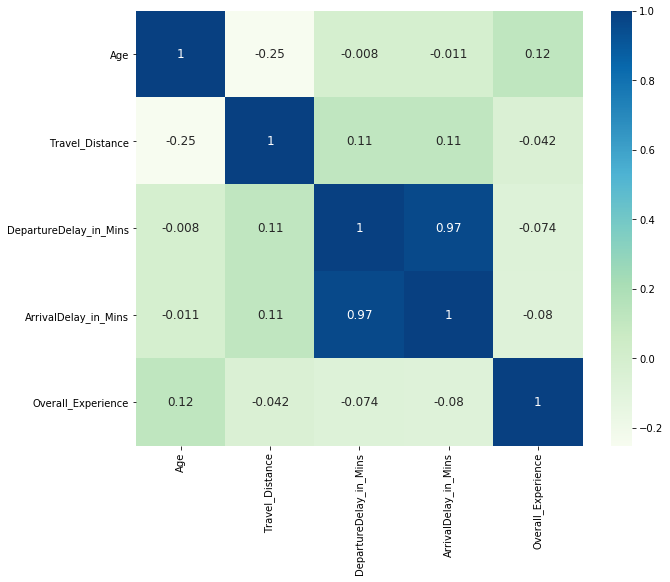

In [168]:
plt.figure(figsize = (10, 8))

sns.heatmap(train_df.corr(), annot = True, annot_kws = {'size': 12}, cmap = 'GnBu')

In [169]:
# missing data

train_df.isna().sum()

Gender                       77
CustomerType               8951
Age                          33
TypeTravel                 9226
Travel_Class                  0
Travel_Distance               0
DepartureDelay_in_Mins       57
ArrivalDelay_in_Mins        357
Overall_Experience            0
Seat_comfort                 61
Seat_Class                    0
Arrival_time_convenient    8930
Catering                   8741
Platform_location            30
Onboardwifi_service          30
Onboard_entertainment        18
Online_support               91
Onlinebooking_Ease           73
Onboard_service            7601
Leg_room                     90
Baggage_handling            142
Checkin_service              77
Cleanliness                   6
Online_boarding               6
dtype: int64

In [170]:
# missing data imputation - median for numeric and mode for categorical

for i in num_train_df:
    train_df[i].fillna(train_df[i].median(), inplace = True)

In [171]:
cat_train_df.isna().sum().sum()

44150

In [172]:
for i in cat_train_df:
    train_df[i].fillna(train_df[i].mode()[0], inplace = True)

In [173]:
train_df.isna().sum().sum()

0

In [174]:
cat_train_df.nunique().sort_values()

Gender                     2
CustomerType               2
TypeTravel                 2
Travel_Class               2
Seat_Class                 2
Checkin_service            5
Baggage_handling           5
Onboard_service            5
Onlinebooking_Ease         5
Online_support             5
Onboardwifi_service        5
Cleanliness                5
Platform_location          5
Online_boarding            5
Catering                   6
Leg_room                   6
Arrival_time_convenient    6
Seat_comfort               6
Onboard_entertainment      6
dtype: int64

In [175]:
train_df['Baggage_handling'].value_counts()

good                35086
excellent           26003
acceptable          17767
need improvement     9759
poor                 5764
Name: Baggage_handling, dtype: int64

In [176]:
# replace = train_df[['Checkin_service', 'Leg_room', 'Onboard_service', 'Onlinebooking_Ease', 'Online_support',
#             'Onboardwifi_service', 'Cleanliness', 'Platform_location', 'Catering', 'Arrival_time_convenient',
#             'Seat_comfort', 'Onboard_entertainment', 'Online_boarding']]

In [177]:
# manual categorical data encoding

train_df['Checkin_service'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Leg_room'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Onboard_service'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Onlinebooking_Ease'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Online_support'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Onboardwifi_service'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Cleanliness'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Platform_location'].replace(['very inconvinient', 'Inconvinient', 'need improvement', 'manageable', 'Convinient', 'very convinient'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Catering'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Arrival_time_convenient'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Seat_comfort'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Onboard_entertainment'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
train_df['Online_boarding'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)

train_df['Baggage_handling'].replace(['poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4], inplace = True)

train_df['Seat_Class'].replace(['Green Car', 'Ordinary'], 
                                    [0, 1], inplace = True)

train_df['Travel_Class'].replace(['Eco', 'Business'], 
                                    [0, 1], inplace = True)

train_df['TypeTravel'].replace(['Business travel', 'Personal Travel'], 
                                    [0, 1], inplace = True)

train_df['CustomerType'].replace(['Loyal Customer', 'disloyal Customer'], 
                                    [0, 1], inplace = True)

train_df['Gender'].replace(['Female', 'Male'], [1, 0], inplace = True)

In [178]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94379 entries, 0 to 94378
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   94379 non-null  int64  
 1   CustomerType             94379 non-null  int64  
 2   Age                      94379 non-null  float64
 3   TypeTravel               94379 non-null  int64  
 4   Travel_Class             94379 non-null  int64  
 5   Travel_Distance          94379 non-null  int64  
 6   DepartureDelay_in_Mins   94379 non-null  float64
 7   ArrivalDelay_in_Mins     94379 non-null  float64
 8   Overall_Experience       94379 non-null  int64  
 9   Seat_comfort             94379 non-null  int64  
 10  Seat_Class               94379 non-null  int64  
 11  Arrival_time_convenient  94379 non-null  int64  
 12  Catering                 94379 non-null  int64  
 13  Platform_location        94379 non-null  int64  
 14  Onboardwifi_service   

In [179]:
#check predictive power score

pps.predictors(train_df, "Overall_Experience")[['x', 'y', 'ppscore']]

,x,y,ppscore
0,Onboard_entertainment,Overall_Experience,0.320894
1,Seat_comfort,Overall_Experience,0.155904
2,Onlinebooking_Ease,Overall_Experience,0.134464
3,Online_support,Overall_Experience,0.098053
4,Leg_room,Overall_Experience,0.058620
5,Online_boarding,Overall_Experience,0.045632
6,Onboard_service,Overall_Experience,0.044086
7,Cleanliness,Overall_Experience,0.016743
8,Baggage_handling,Overall_Experience,0.014898
9,Travel_Class,Overall_Experience,0.014427


<function xlabel at 0x0000026798AFAE58>


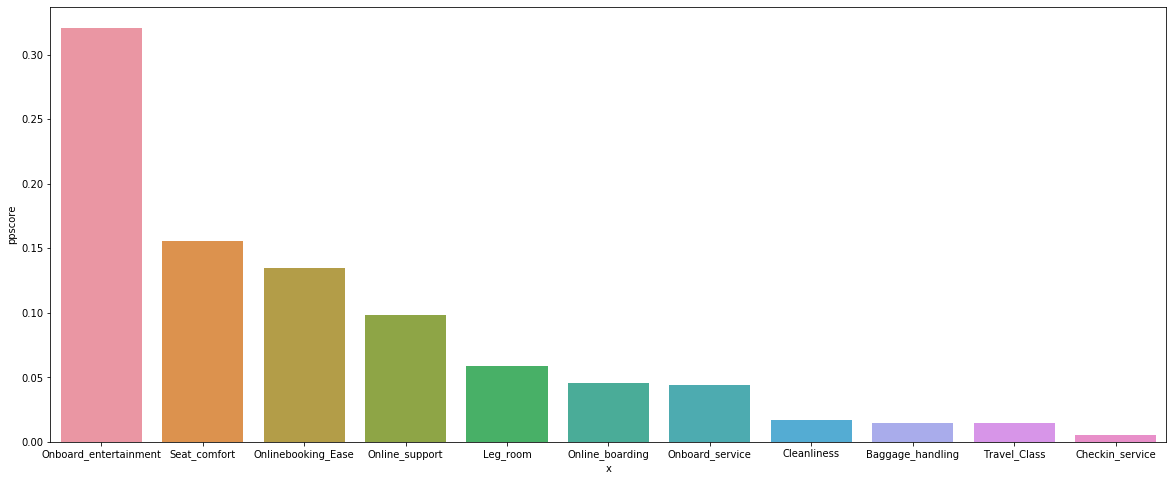

In [180]:
# variables with high predictive power score

plt.figure(figsize = (20, 8))
predictors_df = pps.predictors(train_df, "Overall_Experience")
sns.barplot(data = predictors_df.nlargest(11, 'ppscore'), x= "x", y = "ppscore")
print(plt.xlabel)

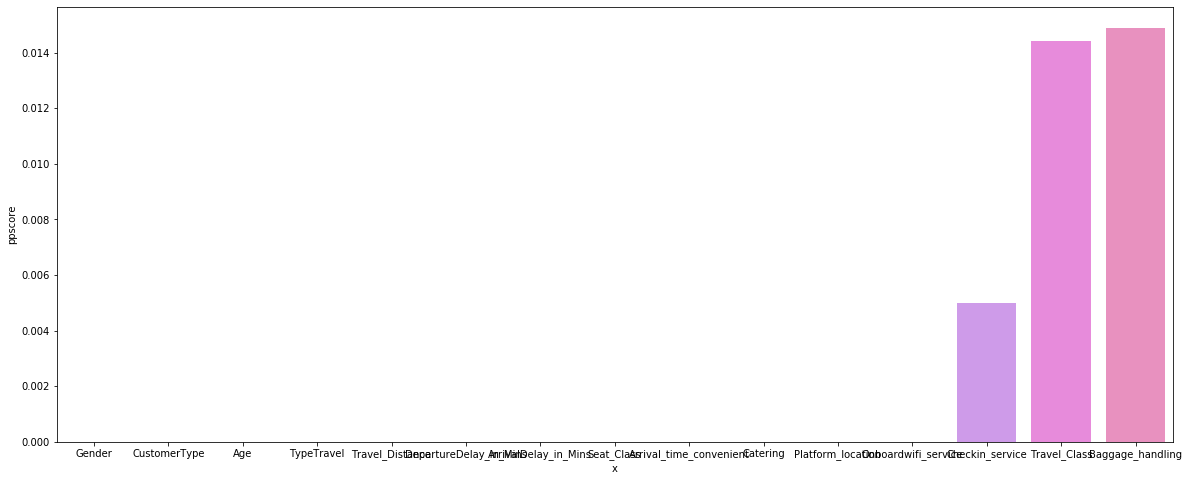

In [181]:
# variables with low predictive power score

plt.figure(figsize = (20, 8))
predictors_df = pps.predictors(train_df, "Overall_Experience")
sns.barplot(data = predictors_df.nsmallest(15, 'ppscore'), x= "x", y = "ppscore")

In [182]:
predictors_df.nsmallest(12, 'ppscore').x

11                     Gender
12               CustomerType
13                        Age
14                 TypeTravel
15            Travel_Distance
16     DepartureDelay_in_Mins
17       ArrivalDelay_in_Mins
18                 Seat_Class
19    Arrival_time_convenient
20                   Catering
21          Platform_location
22        Onboardwifi_service
Name: x, dtype: object

In [183]:
train_df.columns

Index(['Gender', 'CustomerType', 'Age', 'TypeTravel', 'Travel_Class',
       'Travel_Distance', 'DepartureDelay_in_Mins', 'ArrivalDelay_in_Mins',
       'Overall_Experience', 'Seat_comfort', 'Seat_Class',
       'Arrival_time_convenient', 'Catering', 'Platform_location',
       'Onboardwifi_service', 'Onboard_entertainment', 'Online_support',
       'Onlinebooking_Ease', 'Onboard_service', 'Leg_room', 'Baggage_handling',
       'Checkin_service', 'Cleanliness', 'Online_boarding'],
      dtype='object')

In [184]:
# train_df['DepartureDelay_in_Mins'] = np.where(train_df['DepartureDelay_in_Mins'] > 1000, train_df['DepartureDelay_in_Mins'].median(), train_df['DepartureDelay_in_Mins'])
# train_df['ArrivalDelay_in_Mins'] = np.where(train_df['ArrivalDelay_in_Mins'] > 1000, train_df['DepartureDelay_in_Mins'].median(), train_df['ArrivalDelay_in_Mins'])

In [185]:
# train_df['Online_Score'] = train_df['Online_support'] + train_df['Onlinebooking_Ease'] + train_df['Online_boarding']
# train_df['Prior_boarding'] = train_df['Baggage_handling'] + train_df['Catering'] + train_df['Checkin_service']+ train_df['Platform_location']
# train_df['Onboard_Score'] = train_df['Onboard_entertainment'] + train_df['Onboard_service'] + train_df['Onboardwifi_service']
# train_df['Comfort_Score'] = train_df['Cleanliness'] + train_df['Leg_room'] + train_df['Seat_comfort']
# train_df['Covered'] = train_df['DepartureDelay_in_Mins'] - train_df['ArrivalDelay_in_Mins']

train_df['Dep_Delay_HRS'] = train_df['DepartureDelay_in_Mins'] / 60
train_df['Arr_Delay_HRS'] = train_df['ArrivalDelay_in_Mins'] / 60


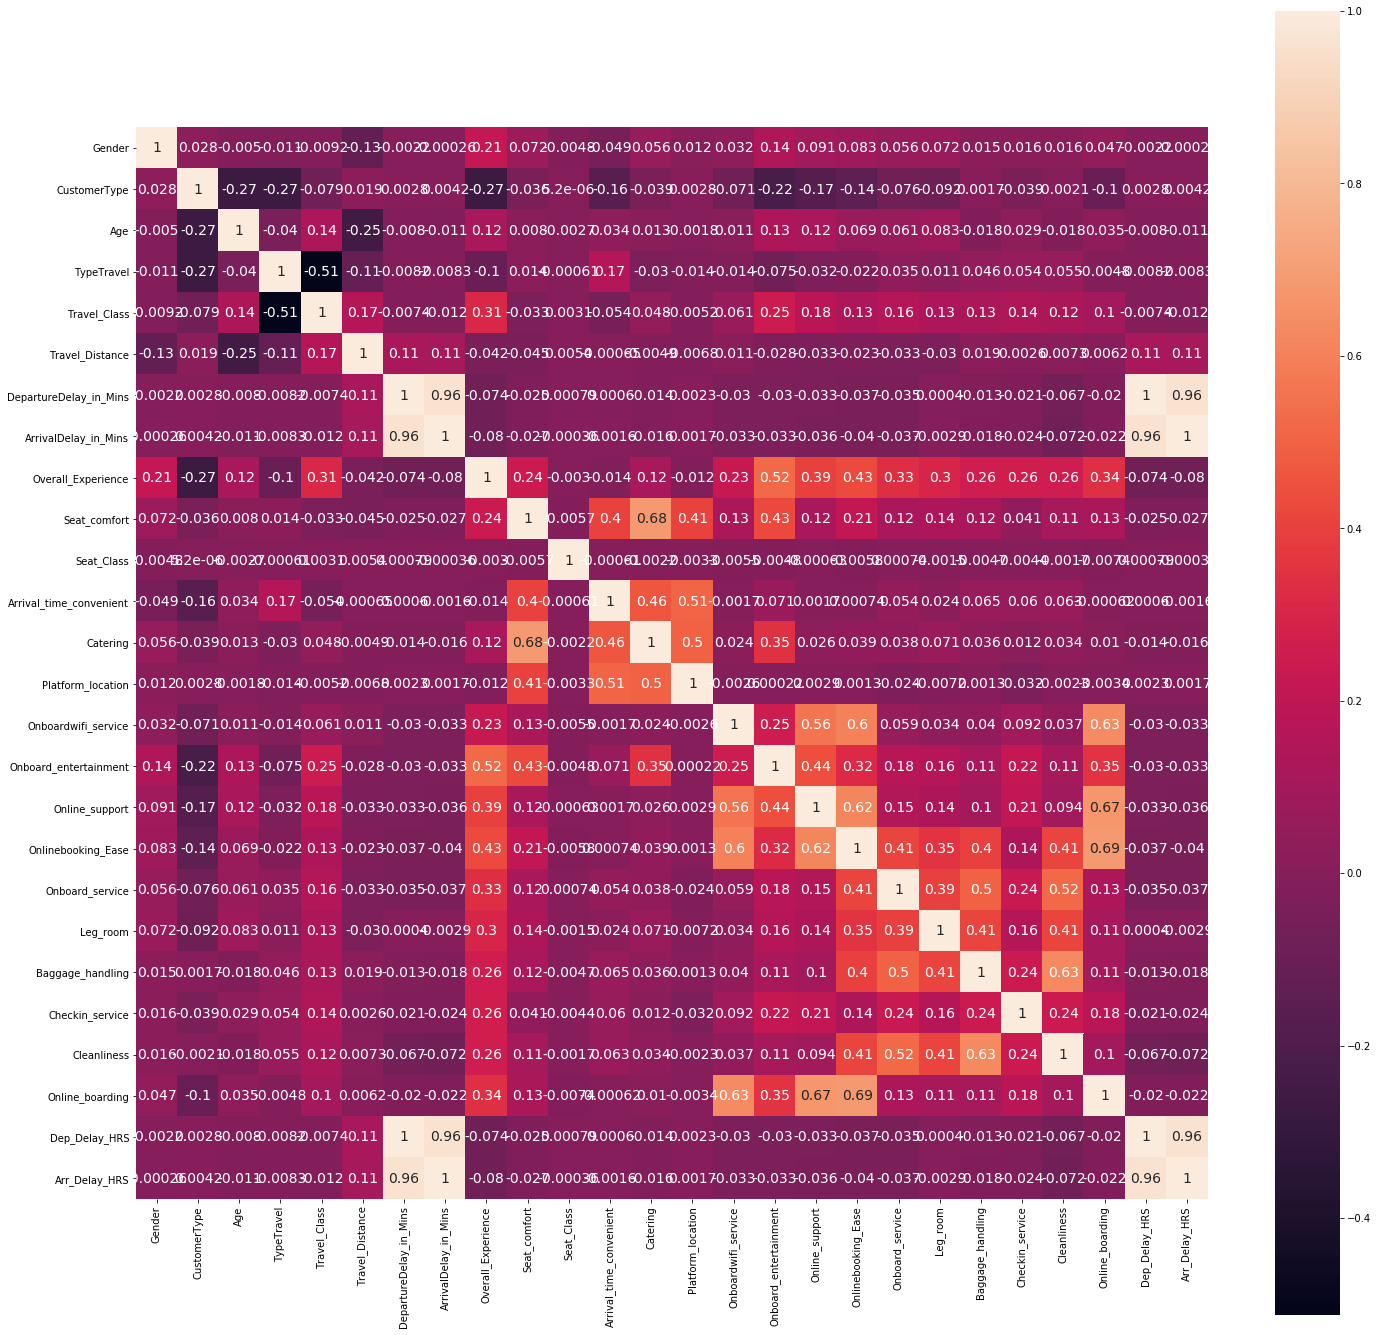

In [186]:
#correlation

plt.figure(figsize = (24, 24))
sns.heatmap(train_df.corr(), annot = True, square = True, annot_kws = {'size': 14})

In [187]:
abs(train_df.corr()['Overall_Experience']).sort_values(ascending = False)

Overall_Experience         1.000000
Onboard_entertainment      0.524749
Onlinebooking_Ease         0.432095
Online_support             0.391823
Online_boarding            0.339114
Onboard_service            0.334343
Travel_Class               0.310013
Leg_room                   0.302461
CustomerType               0.274699
Checkin_service            0.262495
Baggage_handling           0.257585
Cleanliness                0.255578
Seat_comfort               0.243357
Onboardwifi_service        0.229732
Gender                     0.214417
Age                        0.116212
Catering                   0.116200
TypeTravel                 0.100799
ArrivalDelay_in_Mins       0.080027
Arr_Delay_HRS              0.080027
Dep_Delay_HRS              0.073810
DepartureDelay_in_Mins     0.073810
Travel_Distance            0.041582
Arrival_time_convenient    0.014446
Platform_location          0.012316
Seat_Class                 0.002992
Name: Overall_Experience, dtype: float64

In [188]:
# taking same preprocessing steps as training data 

for i in num_test_df:
    test_df[i].fillna(test_df[i].median(), inplace = True)

for i in cat_test_df:
    test_df[i].fillna(test_df[i].mode()[0], inplace = True)

test_df.isna().sum().sum()

0

In [189]:
test_df['Onboardwifi_service'].replace('extremely poor', 'poor', inplace = True)
test_df['Onlinebooking_Ease'].replace('extremely poor', 'poor', inplace = True)
test_df['Online_boarding'].replace('extremely poor', 'poor', inplace = True)

In [190]:
test_df['Checkin_service'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Leg_room'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Onboard_service'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Onlinebooking_Ease'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Online_support'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Onboardwifi_service'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Cleanliness'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Platform_location'].replace(['very inconvinient', 'Inconvinient', 'need improvement', 'manageable', 'Convinient', 'very convinient'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Catering'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Arrival_time_convenient'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Seat_comfort'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Onboard_entertainment'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)
test_df['Online_boarding'].replace(['extremely poor', 'poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4, 5], inplace = True)

test_df['Baggage_handling'].replace(['poor', 'need improvement', 'acceptable', 'good', 'excellent'], 
                                    [0, 1, 2, 3, 4], inplace = True)

test_df['Seat_Class'].replace(['Green Car', 'Ordinary'], 
                                    [0, 1], inplace = True)

test_df['Travel_Class'].replace(['Eco', 'Business'], 
                                    [0, 1], inplace = True)

test_df['TypeTravel'].replace(['Business travel', 'Personal Travel'], 
                                    [0, 1], inplace = True)

test_df['CustomerType'].replace(['Loyal Customer', 'disloyal Customer'], 
                                    [0, 1], inplace = True)

test_df['Gender'].replace(['Female', 'Male'], [1, 0], inplace = True)

In [191]:
# test_df['DepartureDelay_in_Mins'] = np.where(test_df['DepartureDelay_in_Mins'] > 1000, test_df['DepartureDelay_in_Mins'].median(), test_df['DepartureDelay_in_Mins'])
# test_df['ArrivalDelay_in_Mins'] = np.where(test_df['ArrivalDelay_in_Mins'] > 1000, test_df['DepartureDelay_in_Mins'].median(), test_df['ArrivalDelay_in_Mins'])

In [192]:
# test_df['Online_Score'] = test_df['Online_support'] + test_df['Onlinebooking_Ease'] + test_df['Online_boarding']
# test_df['Prior_boarding'] = test_df['Baggage_handling'] + test_df['Catering'] + test_df['Checkin_service']+ test_df['Platform_location']
# test_df['Onboard_Score'] = test_df['Onboard_entertainment'] + test_df['Onboard_service'] + test_df['Onboardwifi_service']
# test_df['Comfort_Score'] = test_df['Cleanliness'] + test_df['Leg_room'] + test_df['Seat_comfort']
# test_df['Covered'] = test_df['DepartureDelay_in_Mins'] - test_df['ArrivalDelay_in_Mins']

test_df['Dep_Delay_HRS'] = test_df['DepartureDelay_in_Mins'] / 60
test_df['Arr_Delay_HRS'] = test_df['ArrivalDelay_in_Mins'] / 60

In [193]:
test_df = test_df.drop(['ID', 'Seat_Class'], axis = 1)

### Modeling

In [194]:
X = train_df.drop(['Overall_Experience', 'Seat_Class'], axis = 1)

y = train_df['Overall_Experience']

In [195]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 1)

# X_train.shape, y_train.shape, X_val.shape, y_val.shape

### MAX VOTING ENSEMBLE - [TEST ACC: 0.9580922]

In [196]:
# NOTE: some below provided hyperparameters might have been altered and is not the set that gave the best test score
# Train accuracy score of 0.9886376934943348 gave the best test score of .9580922 


model1 = CatBoostClassifier(random_state = 1, verbose = False,
                              iterations = 1000,
                              depth = 6,
                              random_strength = 1e-5)

model2 = lgb.LGBMClassifier(random_state = 1,
                              boosting_type = 'gbdt',
                              num_leaves = 31,  
                              max_depth = 12,  
                              n_estimators = 950,  
                              learning_rate = 0.1,
                              colsample_bytree = 0.6,
                              n_jobs = 4)

model3 = XGBClassifier(random_state = 1, 
                         n_jobs = 4,
                         n_estimators = 800,
                         max_depth = 15,   
                         colsample_bylevel = 0.7,
                         learning_rate = 0.0891)



model1.fit(X, y)
model2.fit(X, y)
model3.fit(X, y)


pred1 = model1.predict(test_df)
pred2 = model2.predict(test_df)
pred3 = model3.predict(test_df)


# final test predictions

final_pred = np.array([])
for i in range(0,len(test_df)):
    final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred3[i]]))
    

# scoring on train data   
preda = model1.predict(X)
predb = model2.predict(X)
predc = model3.predict(X)

check_pred = np.array([])
for i in range(0,len(X)):
    check_pred = np.append(check_pred, statistics.mode([preda[i], predb[i], predc[i]]))
    

accuracy_score(y, check_pred)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.9890017906525816

In [197]:
#feature importance 

pd.DataFrame(model3.feature_importances_, index = X.columns, columns = ['Feature Imp']).sort_values('Feature Imp')

,Feature Imp
Travel_Distance,0.004431
Dep_Delay_HRS,0.004760
DepartureDelay_in_Mins,0.004948
Age,0.005643
Arr_Delay_HRS,0.006028
ArrivalDelay_in_Mins,0.006763
Checkin_service,0.010452
Onboard_service,0.010732
Baggage_handling,0.012121
Cleanliness,0.012190


In [143]:
print(confusion_matrix(y, check_pred))

[[42394   392]
 [  699 50894]]


In [144]:
Overall_Experience = pd.DataFrame(final_pred, columns = ['Overall_Experience'])
submission117 = pd.concat([ID, Overall_Experience], axis = 1)
submission117.to_csv('submission00117.csv', index = False)
sub117 = pd.read_csv('submission00117.csv')
sub117.tail()

,ID,Overall_Experience
35597,3135598,0.0
35598,3135599,1.0
35599,3135600,1.0
35600,3135601,1.0
35601,3135602,0.0


## ========== END ==========